In [57]:
import pandas as pd

df = pd.read_csv('analytics_gc.csv')

In [62]:
df = df.rename(columns={'x1': 'Open', 'x2': 'High', 'x3':'Low', 'x4':'Close'})
df.head()

,y,Open,High,Low,Close,op_cl,cl50,bull_h,p02,midOC,midHL
0,0,3861.22,3861.66,3860.75,3861.38,0,1,0,0,3861.300,3861.205
1,0,3861.19,3861.38,3860.16,3861.25,0,1,1,0,3861.220,3860.770
2,0,3861.38,3861.38,3858.47,3858.53,1,0,0,0,3859.955,3859.925
3,1,3858.72,3858.72,3857.03,3858.19,1,0,1,0,3858.455,3857.875
4,1,3858.09,3859.16,3858.03,3858.81,0,1,1,0,3858.450,3858.595


Variance in OHLC = 4884.250276248795, 4881.383565695101, 4889.157196020895, 4884.168947643688
Variance in Mid-Ranges = 4883.781702275199, 4884.990029372724


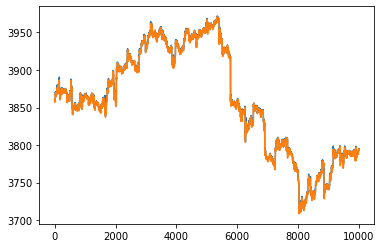

In [63]:
import matplotlib.pyplot as plt
import numpy as np

mid1 = (df['Close']+df['Open'])/2
mid2 = (df['High']+df['Low'])/2

print("Variance in OHLC = "+', '.join([str(np.var(df[x])) for x in ['Open', 'High', 'Low', 'Close']]))
print("Variance in Mid-Ranges = " + ', '.join([str(np.var(x)) for x in [mid1, mid2] ]))

plt.plot(list(range(10**4)), df['Open'])
plt.plot(list(range(10**4)), df['Low'])
plt.show()

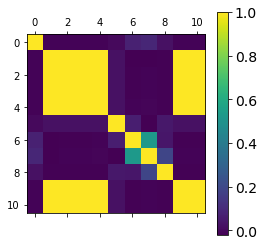

Index(['y', 'Open', 'High', 'Low', 'Close', 'op_cl', 'cl50', 'bull_h', 'p02',
       'midOC', 'midHL'],
      dtype='object')


In [64]:
#See if opening of new datapoint is after closing of prev data point
op_cl = [0]

#Close below or above 50% of previous candlestick
cl50 = [1] #First data point close > half of current.

#Bull Harami, 0.25(O-C) > O-C new 
bull_h = [0]


#Implement more mined parameters from https://discovery.ucl.ac.uk/id/eprint/10062933/1/ICONIP_Deep_Candlestick_Mining_update_final.pdf
#Pattern 02
p02 = [0]

#1 degree patterns
for i in range(1, len(df['Open'])):
    if df['Open'][i] > df['Close'][i-1]:
        op_cl.append(1)
    else:
        op_cl.append(0)
    
    if df['Close'][i] > mid2[i-1]:
        cl50.append(1)
    else:
        cl50.append(0)
    
    if 0.25*(df['Open'][i-1]-df['Close'][i-1]) > (df['Open'][i]-df['Close'][i]):
        bull_h.append(1)
    else:
        bull_h.append(0)

    if df['Open'][i-1]>df['Open'][i] and df['High'][i-1]>df['High'][i] and df['Close'][i-1]<df['Close'][i] and df['Low'][i-1]<df['Low'][i]:
        p02.append(1)
    else:
        p02.append(0)

#2 degree patterns
for i in range(2, len(df['Open'])):
    pass

df['op_cl'] = op_cl
df['cl50'] = cl50
df['bull_h'] = bull_h
df['p02'] = p02

df['midOC'] = mid1
df['midHL'] = mid2
#df['midCompare'] = mid1>mid2, Doesn't do very well though. Check it later.

plt.matshow(df.corr())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

print(df.columns)

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
x = np.array([p02, cl50, bull_h, op_cl]).T
#x=np.array([df["Open"],df["High"],df["Low"],df["Close"]]).T
#scaler = MinMaxScaler(feature_range=(0, 1))
#x = scaler.fit_transform(x)
x = x.astype('float32')
#x = np.array([mid1, mid2]).T
y = np.array(df['y'])
x_train, x_test, y_train, y_test = x[:int(0.8*x.shape[0])],x[int(0.8*x.shape[0]):], y[:int(0.8*x.shape[0])], y[int(0.8*x.shape[0]):]

In [66]:
print(x)

[[0. 1. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 1. 1.]
 [0. 0. 0. 1.]
 [1. 1. 1. 0.]]


0.5475


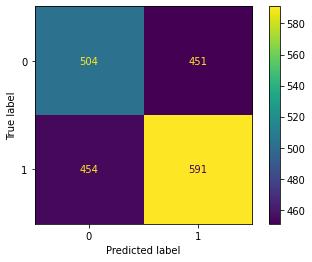

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

#For SVC Hyperplane
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib.pyplot as plt

#model_test = RandomForestClassifier(max_depth=50, n_estimators=50)
#model_test = LogisticRegression(penalty='l2', max_iter=100, dual=False)
model_test = make_pipeline(StandardScaler(), SVC(gamma='auto', C=0.5))


model_test.fit(x_train, y_train)
preds = model_test.predict(x_test)
#print(model_test.feature_importances_)

c = sum([1 if preds[i]==y_test[i] else 0 for i in range(len(preds))])
print(c/len(preds))

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [68]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
model = XGBClassifier()
model.fit(x_train,y_train)
preds = model.predict(x_test)
print(cross_val_score(model,x_train,y_train))
print(accuracy_score(y_test,preds))

[0.54375  0.535625 0.535625 0.54375  0.541875]
0.549


In [69]:
x_train, x_val, x_test, y_train, y_val, y_test = x[:int(0.7*x.shape[0])],x[int(0.7*x.shape[0]):int(0.9*x.shape[0])], x[int(0.9*x.shape[0]):], y[:int(0.7*y.shape[0])],y[int(0.7*y.shape[0]):int(0.9*y.shape[0])], y[int(0.9*y.shape[0]):]

x_train_dl = []
y_train_dl = []
mean_x = np.mean(x_train,axis=0)
mean_y = np.mean(y_train)
look_back = 5
for i in range(len(x_train)):
  if i<look_back-1:
    arr_x = []
    arr_y = []
    for j in range(look_back):
      if j<look_back-1-i:
        arr_x.append(mean_x)
        arr_y.append(mean_y)
      else:
        arr_x.append(x_train[i-look_back+1+j])
        arr_y.append(y_train[i-look_back+1+j])
    x_train_dl.append(arr_x)
    y_train_dl.append(arr_y)
  else:
    x_train_dl.append(x_train[i-look_back+1:i+1])
    y_train_dl.append(y_train[i-look_back+1:i+1])
x_train_dl = np.array(x_train_dl)
y_train_dl = np.array(y_train_dl)

In [70]:
x_test_dl = []
y_test_dl = []
mean_x = np.mean(x_test,axis=0)
mean_y = np.mean(y_test)
for i in range(len(x_test)):
  if i<look_back-1:
    arr_x = []
    arr_y = []
    for j in range(look_back):
      if j<look_back-1-i:
        arr_x.append(mean_x)
        arr_y.append(mean_y)
      else:
        arr_x.append(x_test[i-look_back+1+j])
        arr_y.append(y_test[i-look_back+1+j])
    x_test_dl.append(arr_x)
    y_test_dl.append(arr_y)
  else:
    x_test_dl.append(x_test[i-look_back+1:i+1])
    y_test_dl.append(y_test[i-look_back+1:i+1])
x_test_dl = np.array(x_test_dl)
y_test_dl = np.array(y_test_dl)

In [71]:
x_val_dl = []
y_val_dl = []
mean_x = np.mean(x_val,axis=0)
mean_y = np.mean(y_val)
for i in range(len(x_val)):
  if i<look_back-1:
    arr_x = []
    arr_y = []
    for j in range(look_back):
      if j<look_back-1-i:
        arr_x.append(mean_x)
        arr_y.append(mean_y)
      else:
        arr_x.append(x_val[i-look_back+1+j])
        arr_y.append(y_val[i-look_back+1+j])
    x_val_dl.append(arr_x)
    y_val_dl.append(arr_y)
  else:
    x_val_dl.append(x_val[i-look_back+1:i+1])
    y_val_dl.append(y_val[i-look_back+1:i+1])
x_val_dl = np.array(x_val_dl)
y_val_dl = np.array(y_val_dl)

In [72]:
#Make Neural Model Here.
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense

x = tf.keras.Input(shape=(look_back,4), dtype=float)
y = tf.keras.layers.LSTM(look_back, return_sequences=True,return_state=True,dropout = 0.2, recurrent_dropout = 0.2)(x)
y = tf.keras.layers.LSTM(look_back, return_sequences=True,dropout=0.2,recurrent_dropout=0.2)(x)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dense(1, activation='sigmoid')(y)
model = tf.keras.Model(x,y)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [73]:
model.fit(x_train_dl,y_train, validation_data = (x_val_dl,y_val), epochs=40, batch_size = 30, callbacks=[callback])
model.evaluate(x_test_dl, y_test)

Epoch 1/40
234/234 [==============================] - 4s 7ms/step - loss: 0.6935 - accuracy: 0.5064 - val_loss: 0.6938 - val_accuracy: 0.4980
Epoch 2/40
234/234 [==============================] - 1s 6ms/step - loss: 0.6927 - accuracy: 0.5083 - val_loss: 0.6932 - val_accuracy: 0.5100
Epoch 3/40
234/234 [==============================] - 1s 6ms/step - loss: 0.6919 - accuracy: 0.5193 - val_loss: 0.6930 - val_accuracy: 0.5025
Epoch 4/40
234/234 [==============================] - 1s 5ms/step - loss: 0.6919 - accuracy: 0.5191 - val_loss: 0.6925 - val_accuracy: 0.5110
Epoch 5/40
234/234 [==============================] - 1s 6ms/step - loss: 0.6913 - accuracy: 0.5301 - val_loss: 0.6916 - val_accuracy: 0.5195
Epoch 6/40
234/234 [==============================] - 1s 5ms/step - loss: 0.6910 - accuracy: 0.5270 - val_loss: 0.6913 - val_accuracy: 0.5290
Epoch 7/40
234/234 [==============================] - 1s 6ms/step - loss: 0.6903 - accuracy: 0.5219 - val_loss: 0.6910 - val_accuracy: 0.5200
Epoch 

[0.6866918206214905, 0.5630000233650208]

In [74]:
model.save('weights.h5')

In [ ]:
import h5py
f = h5py.File('weights.h5', 'r')

In [ ]:
f.close()

In [75]:
df = pd.read_csv('test_gc.csv')
df = df.rename(columns={'x1': 'Open', 'x2': 'High', 'x3':'Low', 'x4':'Close'})

#See if opening of new datapoint is after closing of prev data point
op_cl = [0]

#Close below or above 50% of previous candlestick
cl50 = [1] #First data point close > half of current.

#Bull Harami, 0.25(O-C) > O-C new 
bull_h = [0]


#Implement more mined parameters from https://discovery.ucl.ac.uk/id/eprint/10062933/1/ICONIP_Deep_Candlestick_Mining_update_final.pdf
#Pattern 02
p02 = [0]

#1 degree patterns
for i in range(1, len(df['Open'])):
    if df['Open'][i] > df['Close'][i-1]:
        op_cl.append(1)
    else:
        op_cl.append(0)
    
    if df['Close'][i] > mid2[i-1]:
        cl50.append(1)
    else:
        cl50.append(0)
    
    if 0.25*(df['Open'][i-1]-df['Close'][i-1]) > (df['Open'][i]-df['Close'][i]):
        bull_h.append(1)
    else:
        bull_h.append(0)

    if df['Open'][i-1]>df['Open'][i] and df['High'][i-1]>df['High'][i] and df['Close'][i-1]<df['Close'][i] and df['Low'][i-1]<df['Low'][i]:
        p02.append(1)
    else:
        p02.append(0)

#2 degree patterns
for i in range(2, len(df['Open'])):
    pass

df['op_cl'] = op_cl
df['cl50'] = cl50
df['bull_h'] = bull_h
df['p02'] = p02

df['midOC'] = mid1
df['midHL'] = mid2

test_final = np.array([p02, cl50, bull_h, op_cl]).T

In [76]:
x_test_final = []
mean_x = np.mean(test_final,axis=0)
look_back = 5
for i in range(len(test_final)):
  if i<look_back-1:
    arr_x = []
    for j in range(look_back):
      if j<look_back-1-i:
        arr_x.append(mean_x)
      else:
        arr_x.append(test_final[i-look_back+1+j])
    x_test_final.append(arr_x)
  else:
    x_test_final.append(test_final[i-look_back+1:i+1])
x_test_final = np.array(x_test_final)

In [77]:
y_result = model.predict(x_test_final)

In [78]:
y_result = (y_result > 0.5).astype(int).tolist()
y_result = [i[0] for i in y_result]

In [79]:
data = {'y': y_result}
df = pd.DataFrame(data)

In [80]:
df.to_csv('result.csv', index=False)